Set up environment

In [1]:
import os, sys
import pickle
import numpy as np
from scipy import stats
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


from modules.clustering import *
from modules.munging import *
from modules.visualization import *
from modules.autoencoders import *

sns_styleset()

/home/ozvar/Dropbox/PhD/Main/06_Projects/practice_spacing/lol/analysis/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ozvar/Dropbox/PhD/Main/06_Projects/practice_spacing/lol/analysis/venv/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:22: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


Load data

In [2]:
preprocessed = True
if preprocessed:
    data_path = os.path.join('data', 'df_100_100.csv')
    df = pd.read_csv(data_path)

Set path for figures

In [3]:
fig_dir = os.path.join('figures', 'appendix')

### Some notes on the data set

- All accounts in the data set are "fresh" for this season
- All recorded games are "ranked" games
- We don't know how many unranked games players have played prior to being recorded in this data set
- We don't know how many unranked games players have played in between ranked games recorded in this data set
- We are agnostic to "smurfs" and multiple players who play on the same account

Here's what the data look like

In [4]:
df.head()

,account_id,region,neutral_creeps,enemy_creeps,time_stamp_end,time_stamp,date,hour,gold,damage_dealt,time_dead,time_played,kills,deaths,assists,rating,position,gpm,gpm_delta,kda,kdr,nth_match,win,time_gap,nth_day
0,110230,EUW1,60.00000,58.00000,1454358371694.00000,1454357029694.00000,2016-02-01,20.00000,12869.00000,30983.00000,71.00000,1342.00000,16.00000,2.00000,8.00000,0.49281,JUNGLE,607.50590,31.34535,12.00000,8.00000,1,True,NaN,1
1,110230,EUW1,26.00000,274.00000,1454361418565.00000,1454358950565.00000,2016-02-01,20.00000,21689.00000,51445.00000,431.00000,2468.00000,25.00000,8.00000,6.00000,0.49897,MIDDLE,638.85125,-64.62256,3.87500,3.12500,2,True,0.16080,1
2,110230,EUW1,19.00000,301.00000,1454434421377.00000,1454431416377.00000,2016-02-02,16.00000,23017.00000,64298.00000,600.00000,3005.00000,17.00000,12.00000,10.00000,0.51211,MIDDLE,574.22869,-131.28217,2.25000,1.41667,3,False,19.44384,2
3,110230,EUW1,21.00000,283.00000,1454518167963.00000,1454516075963.00000,2016-02-03,16.00000,14632.00000,21130.00000,110.00000,2092.00000,4.00000,3.00000,4.00000,0.49651,TOP,442.94652,-23.85416,2.66667,1.33333,4,True,22.68183,3
4,110230,EUW1,0.00000,127.00000,1454520130884.00000,1454518690884.00000,2016-02-03,16.00000,8773.00000,13108.00000,184.00000,1440.00000,9.00000,7.00000,1.00000,0.51129,MIDDLE,419.09236,258.58113,1.42857,1.28571,5,False,0.14526,3


How many players do we have?

In [5]:
n_players = df['account_id'].nunique()
print(f'We have a total of {n_players} players in the data set')
print(f'We have a total of {len(df)} rows in the data set')

We have a total of 162417 players in the data set
We have a total of 16241700 rows in the data set


How long does the average game take?

In [6]:
(df['time_played'] / 60).round(2).describe()

count   16241700.00000
mean          33.29607
std            8.05273
min           15.00000
25%           27.55000
50%           32.72000
75%           38.33000
max          343.53000
Name: time_played, dtype: float64

Specify "training" window

In [7]:
n_matches = 100

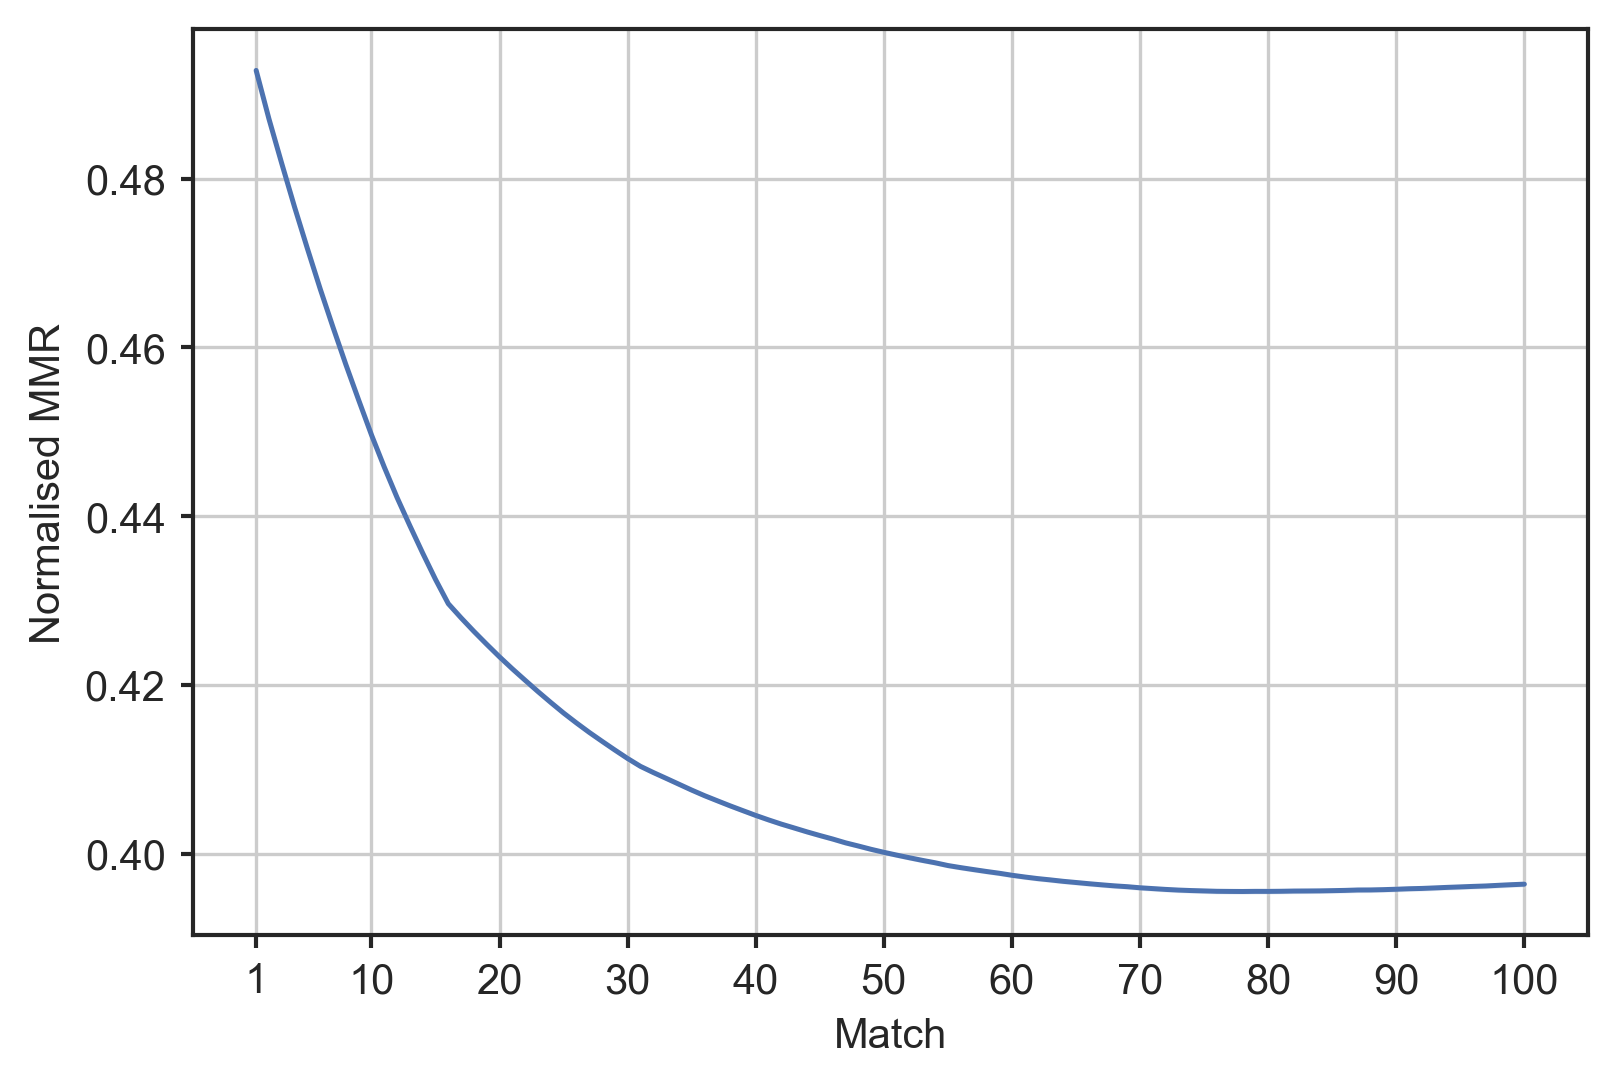

In [8]:
error_line(df, 'rating', n_matches, xlabel='Match', ylabel='Normalised MMR')
plt.show()

Plot this again with loss percentage to check correspondence with drop in rating

In [9]:
rating_means = df.groupby('nth_match')['rating'].mean().tolist()
loss_percent = df.groupby('nth_match').apply(lambda x: len(x[x['win'] == False]) / len(x)).tolist()

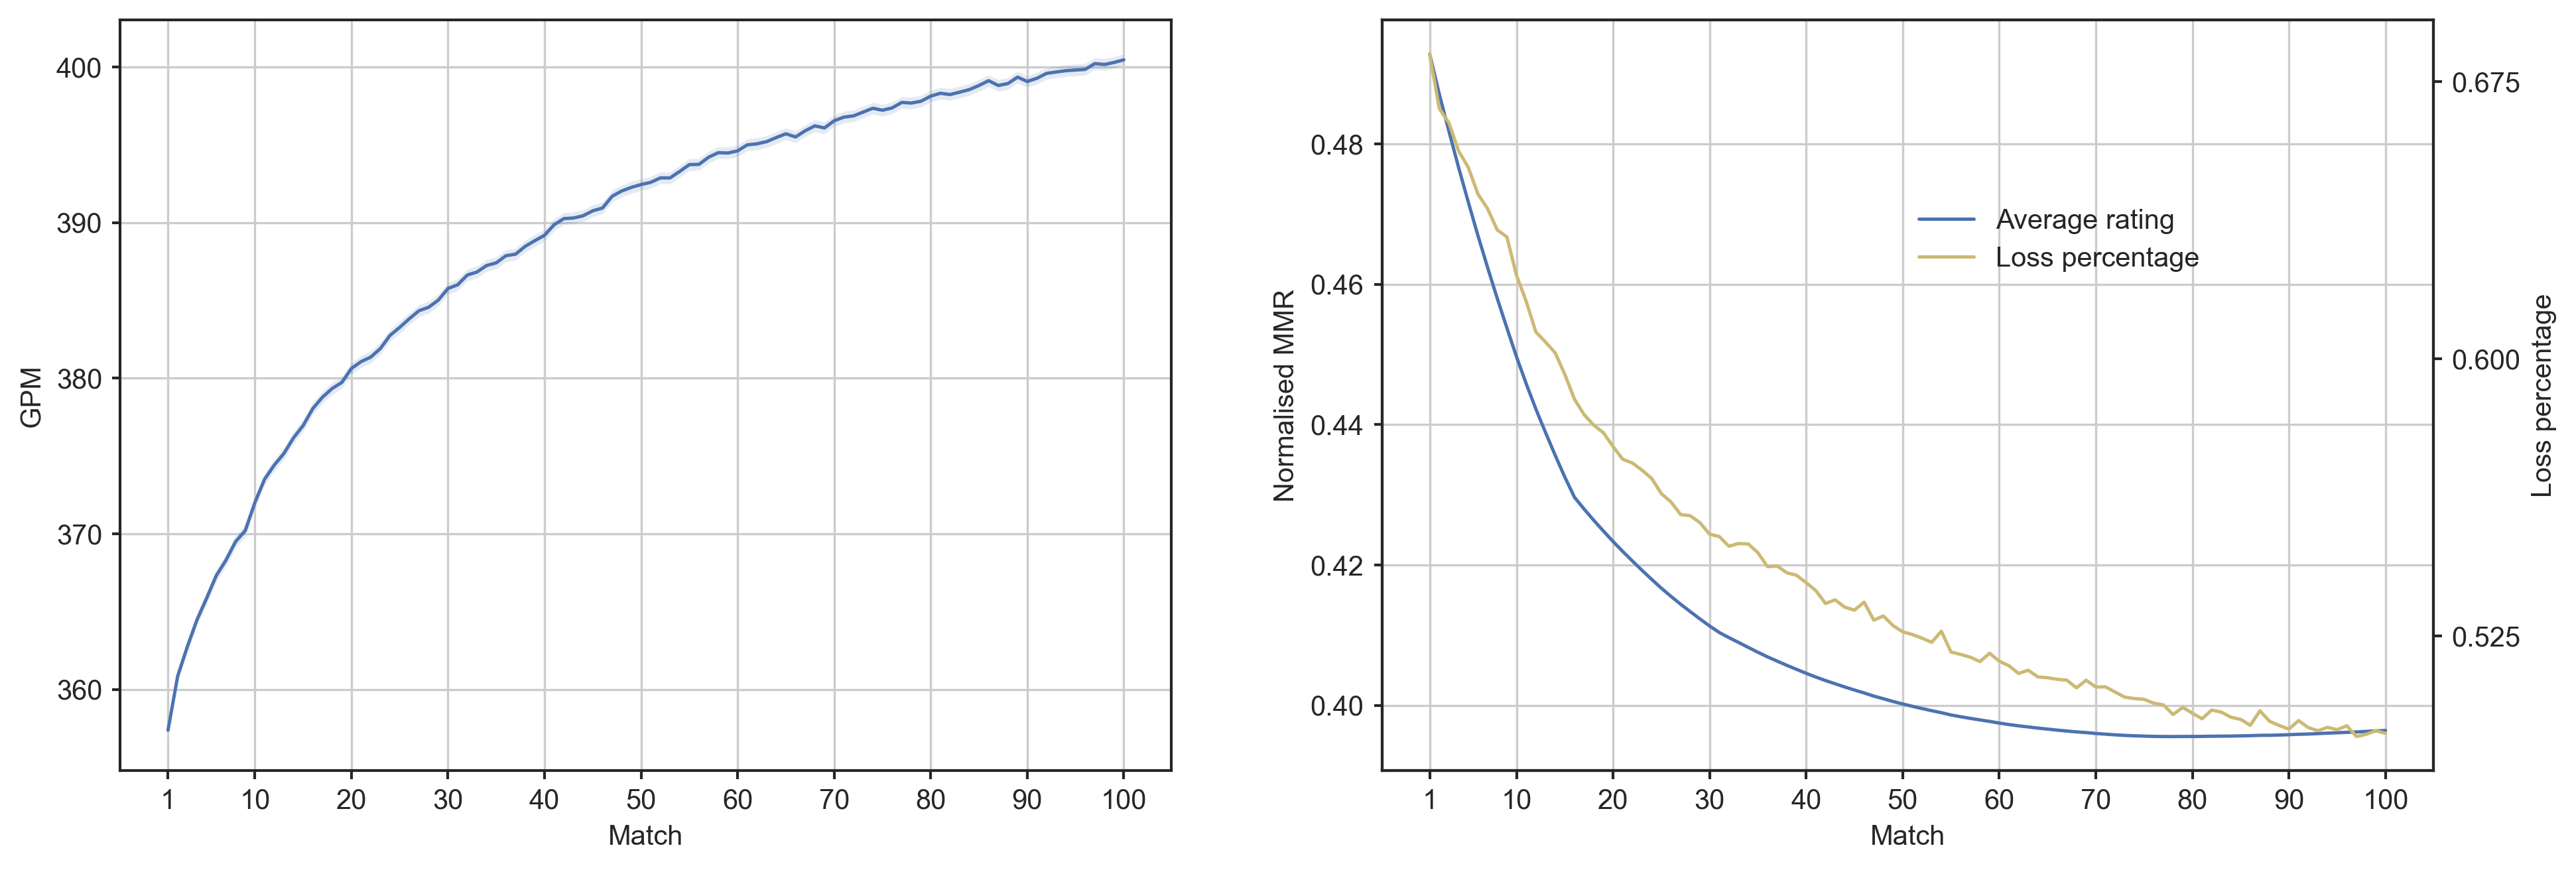

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# this block of code adjusts x axis ticks based on number of matches specified in analysis 
xticks = [1]
xticks.extend(list(range(n_matches // 10,
                         n_matches + n_matches // 10,
                         n_matches // 10 if n_matches // 10 != 0 else 1)))

# first subplot of gpm
means = compute_means(df, 'gpm', n_matches)
errors = compute_errors(df, 'gpm', n_matches)
ax1.set_xlabel('Match')
ax1.set_ylabel('GPM')
ax1.plot(np.arange(1, n_matches + 1), means)
ax1.fill_between(np.arange(1, n_matches + 1),
                 [means[i] + errors[i]*1.96 for i in range(n_matches)],
                 [means[i] - errors[i]*1.96 for i in range(n_matches)],
                 alpha=0.15)
ax1.set_xticks(xticks)

# second subplot of MMR
ax2.set_xlabel('Match')
ax2.set_ylabel('Normalised MMR')
ax2.plot(np.arange(1, n_matches + 1), rating_means)
ax2.tick_params(axis='y')
ax2.set_xticks(xticks)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

# plot loss percentage in second subplot adjacent to MMR
color = 'y'
ax3.set_ylabel('Loss percentage')
ax3.plot(np.arange(1, n_matches + 1), loss_percent, color=color)
ax3.tick_params(axis='y')
ax3.set_yticks(np.arange(0.675, 0.5, -0.075))
ax3.grid(None)

# legend
ax2.legend(['Average rating', 'Loss percentage'], loc=(0.5, 0.7), frameon=False)
ax3.legend(['Loss percentage'], loc=(0.5, 0.65), frameon=False)

fig_name = f'loss_gpm_rating_curves_{n_matches}_matches'
plt.savefig(os.path.join(fig_dir, f'{fig_name}.png'))
plt.savefig(os.path.join(fig_dir, f'{fig_name}.tif'), format='tiff')

plt.show()

In [11]:
data = create_summary_dataframe(
    df=df,
    dvs=['rating', 'gpm'],
    n_matches=100,
    head=5,
    tail=5,
    spacing='time_delta',
    verbose=True)

,account_id,spacing,rating_initial_perf,rating_acquisition,gpm_initial_perf,gpm_acquisition
0,110230,46.07930,0.50234,0.03598,536.52494,0.96338
1,112510,27.02594,0.50489,0.10382,500.81889,-38.16694
2,116931,31.39937,0.46275,-0.19688,294.54405,56.32999
3,132136,78.97467,0.46177,-0.24969,336.97602,43.92761
4,138478,92.06123,0.46341,-0.15869,368.30855,100.87922


In [12]:
# declare intervals based on head, middle, and tail of histogram above
intervals = [(1, 15), (76, 90), (136, 150)]
# split summary df and main df into groups based on spacing intervals
groups = [data[(data['spacing'].between(i[0], i[1]))] for i in intervals]
groups_df = [df[df['account_id'].isin(group['account_id'].tolist())] for group in groups]
# get number of players in each group
[group['account_id'].nunique() for group in groups]

[11963, 13120, 3545]

In [13]:
# add spacing group label to df
for group in zip(groups_df, intervals):
    label = f"{group[1][0]} - {group[1][1]} days"
    print(label)
    group[0]['rule_cluster'] = label 
groups_df = pd.concat(groups_df)

1 - 15 days
76 - 90 days
136 - 150 days


/tmp/ipykernel_26372/1952042433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[0]['rule_cluster'] = label


Plot performance trajectories with 95% CIs for each group

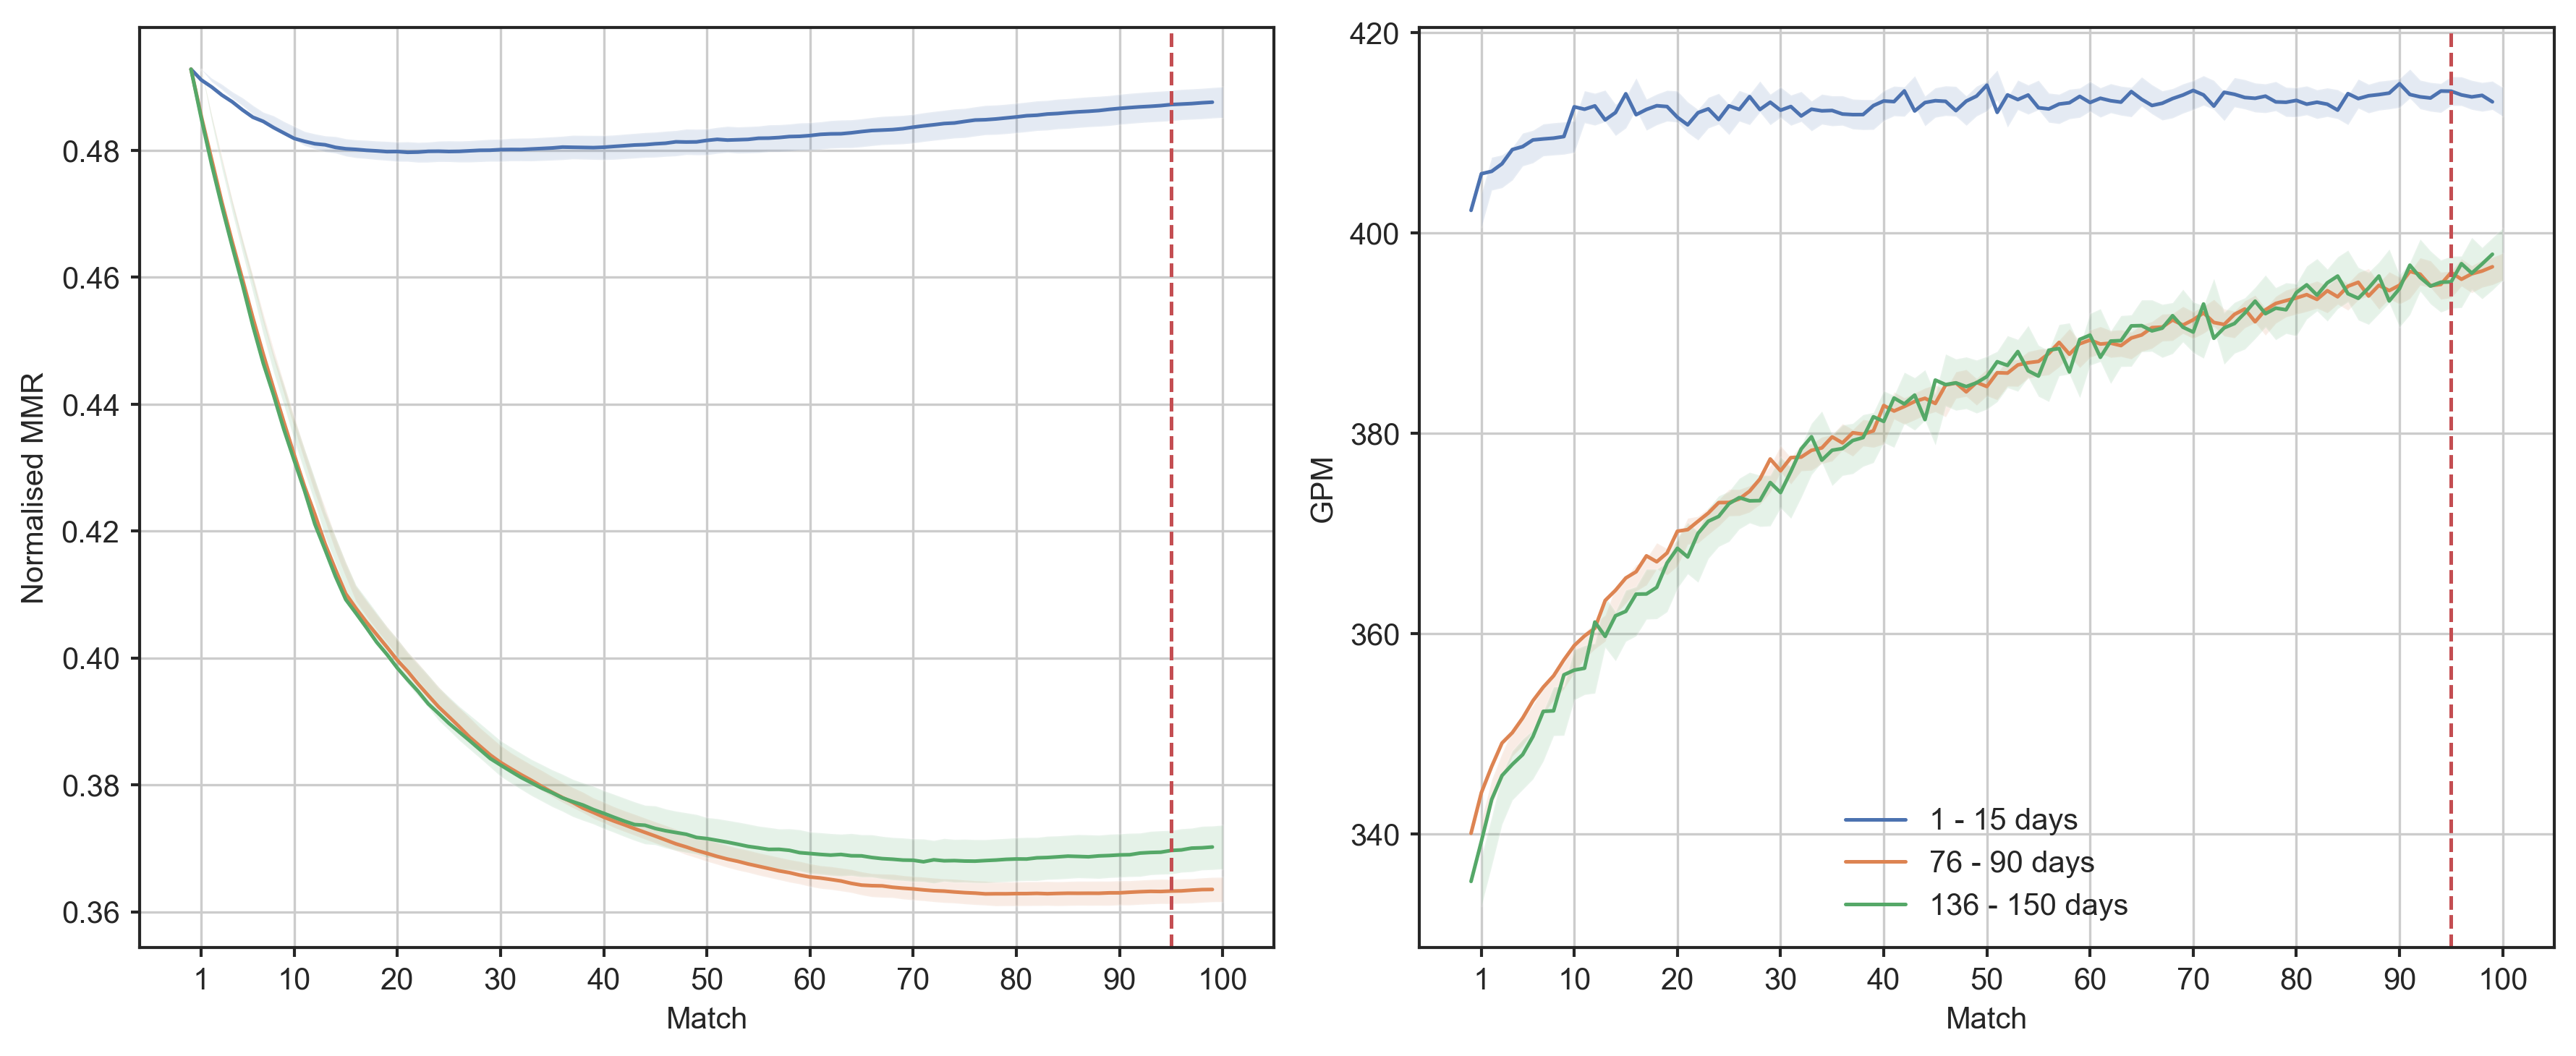

In [14]:
TARGETS = [
    'rating',
    'gpm'
]

target_rmp = {
    'rating': 'Normalised MMR',
    'gpm': 'GPM'
}

curves_visualizer(
    df=groups_df,
    grouper='rule_cluster',
    targets=TARGETS,
    rows=1,
    columns=2,
    n_matches=100,
    fig_size=(12, 5),
    fig_dir=fig_dir,
    fig_name=f'spacing_groups_normalised_mmr_and_gpm_trajectories_{n_matches}_matches',
    grouper_rmp=None,
    target_rmp=target_rmp,
    legend=True)

### Matching on initial performance

Spacing relates to acquisition but appears strongly confounded by initial ability - we try to control for this here

In [15]:
print(data['rating_initial_perf'].describe())
print(data['gpm_initial_perf'].describe())

count   162417.00000
mean         0.48200
std          0.01760
min          0.30472
25%          0.46686
50%          0.48025
75%          0.49314
max          0.59039
Name: rating_initial_perf, dtype: float64
count   162417.00000
mean       362.26152
std         63.72333
min        195.16990
25%        315.38942
50%        350.85369
75%        399.88591
max        734.25728
Name: gpm_initial_perf, dtype: float64


Subsample players with similar initial performance

In [16]:
rating_subsample = data[data['rating_initial_perf'].between(0.432, 0.528)]  # median initial_perf +- 0.48
print(f'There are {len(rating_subsample)} players in the subsample matched on median initial normalised MMR')
gpm_subsample = data[data['gpm_initial_perf'].between(325, 375)]  # median initial_perf +- 25
print(f'There are {len(gpm_subsample)} players in the subsample matched on median initial GPM performance')

There are 162280 players in the subsample matched on median initial normalised MMR
There are 52440 players in the subsample matched on median initial GPM performance


In [17]:
# split summary df and main df into groups based on spacing intervals
rating_groups = [rating_subsample[(rating_subsample['spacing'].between(i[0], i[1]))] for i in intervals]
rating_groups_df = [df[df['account_id'].isin(group['account_id'].tolist())] for group in rating_groups]
# get number of players in each group
[group['account_id'].nunique() for group in rating_groups]

[11956, 13109, 3542]

In [18]:
# split summary df and main df into groups based on spacing intervals
gpm_groups = [gpm_subsample[(gpm_subsample['spacing'].between(i[0], i[1]))] for i in intervals]
gpm_groups_df = [df[df['account_id'].isin(group['account_id'].tolist())] for group in gpm_groups]
# get number of players in each group
[group['account_id'].nunique() for group in gpm_groups]

[2790, 4510, 1236]

Subsample based on initial performance range and replot - for normalised MMR this will look the same as all players initialise at the same value

In [19]:
accounts_to_retain={'gpm': pd.concat(gpm_groups_df)['account_id'].unique(),
                    'rating': pd.concat(rating_groups_df)['account_id'].unique()}

Plot performance trajectories with 95% CIs for each group

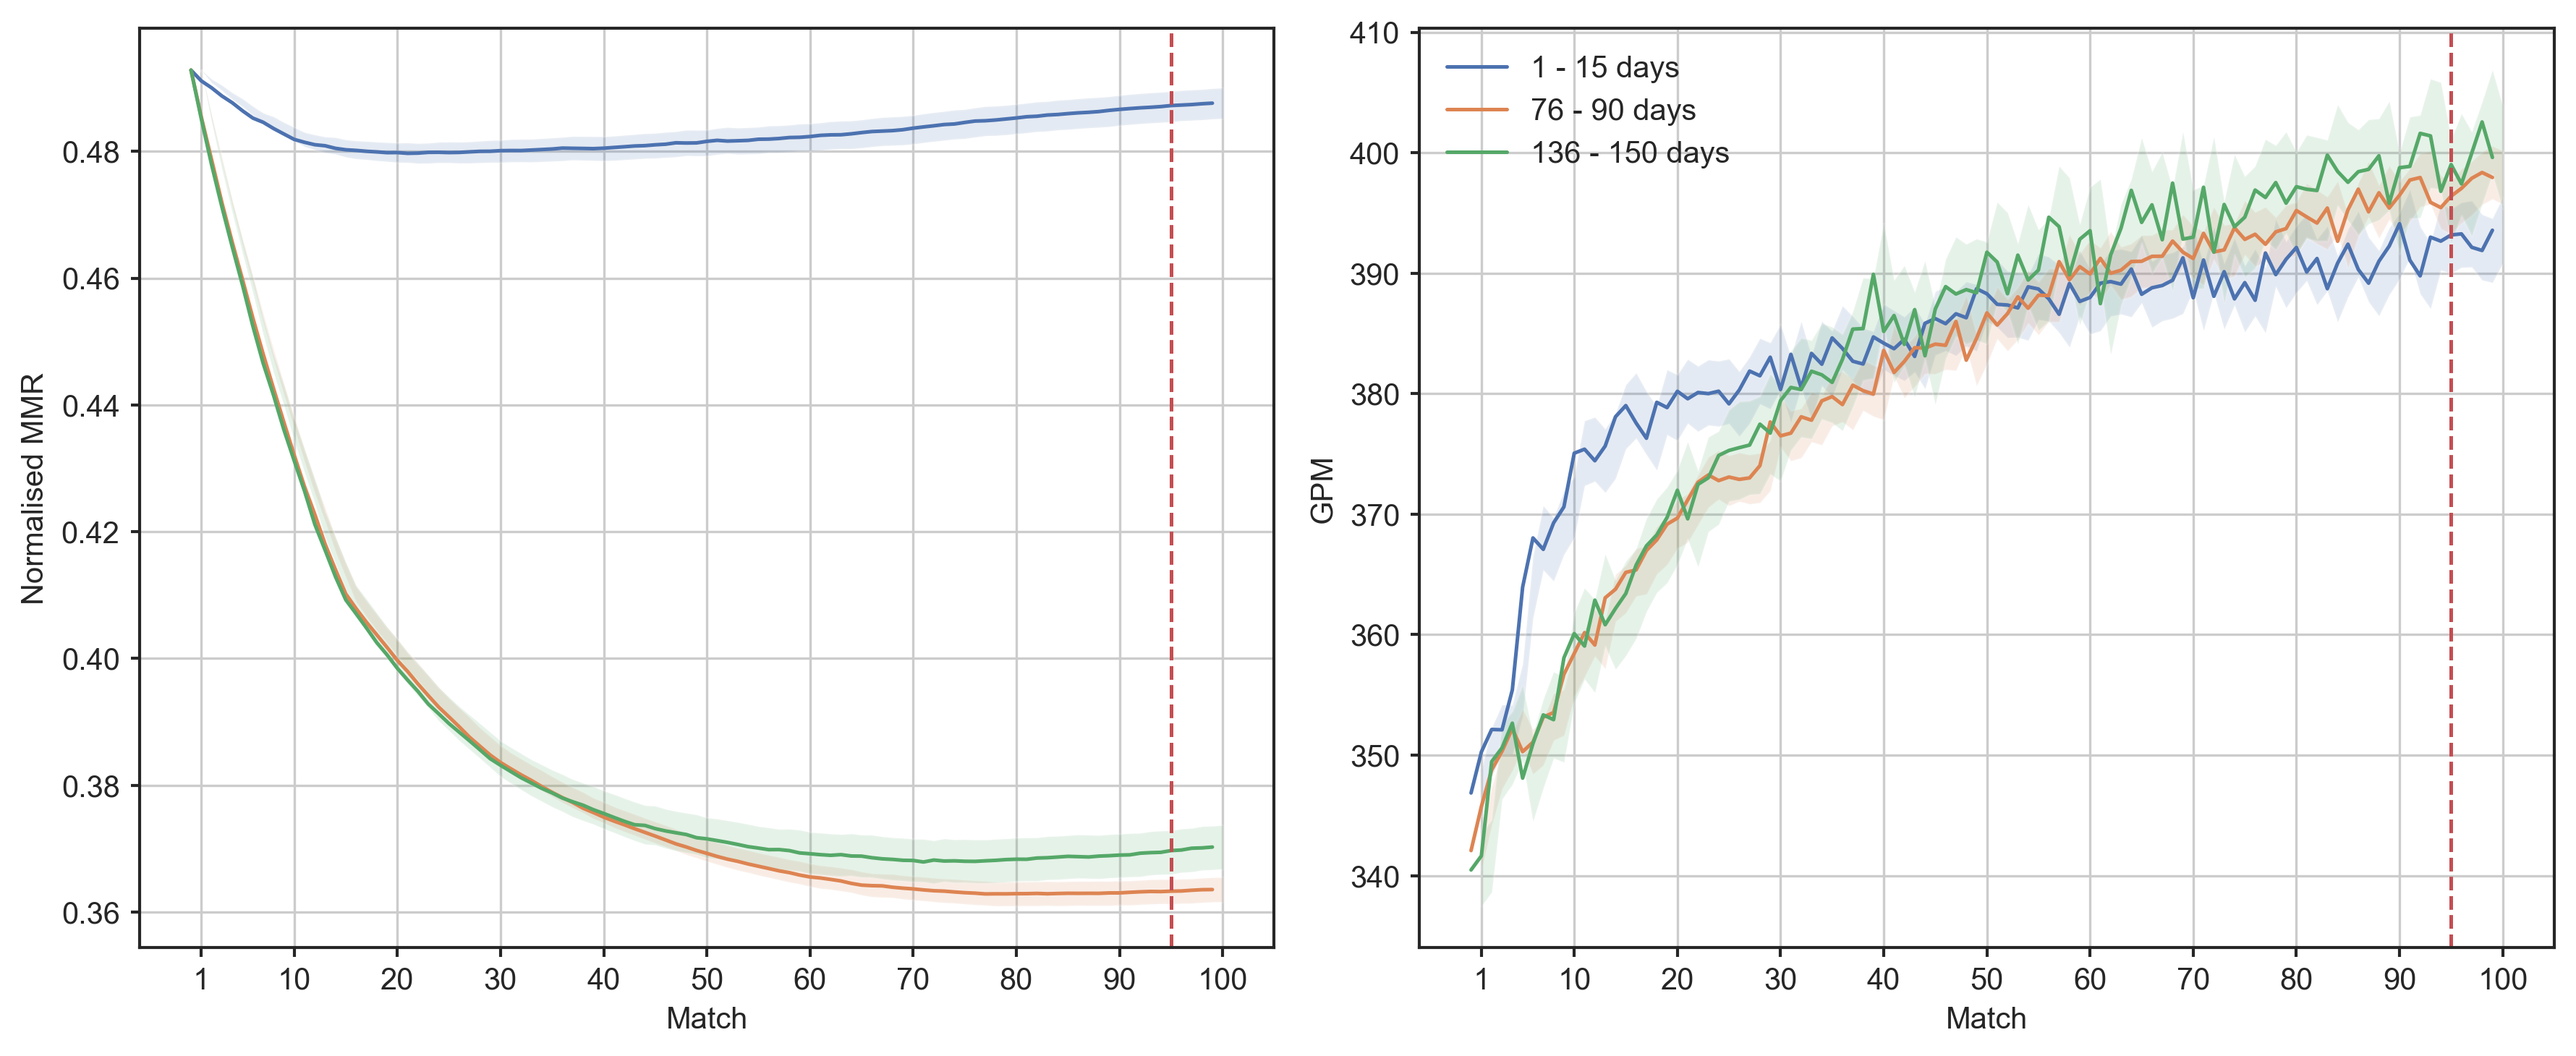

In [20]:
curves_visualizer(
    df=groups_df,
    grouper='rule_cluster',
    targets=TARGETS,
    rows=1,
    columns=2,
    n_matches=100,
    fig_size=(12, 5),
    fig_dir=fig_dir,
    fig_name=f'matched_spacing_groups_normalised_mmr_gpm_trajectories_{n_matches}_matches',
    grouper_rmp=None,
    target_rmp=target_rmp,
    legend=True,
    accounts_to_retain=accounts_to_retain)

Redo, replot MMR using the subsample of players matched on initial GPM instead

In [21]:
accounts_to_retain={'gpm': pd.concat(gpm_groups_df)['account_id'].unique(),
                    'rating': pd.concat(gpm_groups_df)['account_id'].unique()}

Plot performance trajectories with 95% CIs for each group

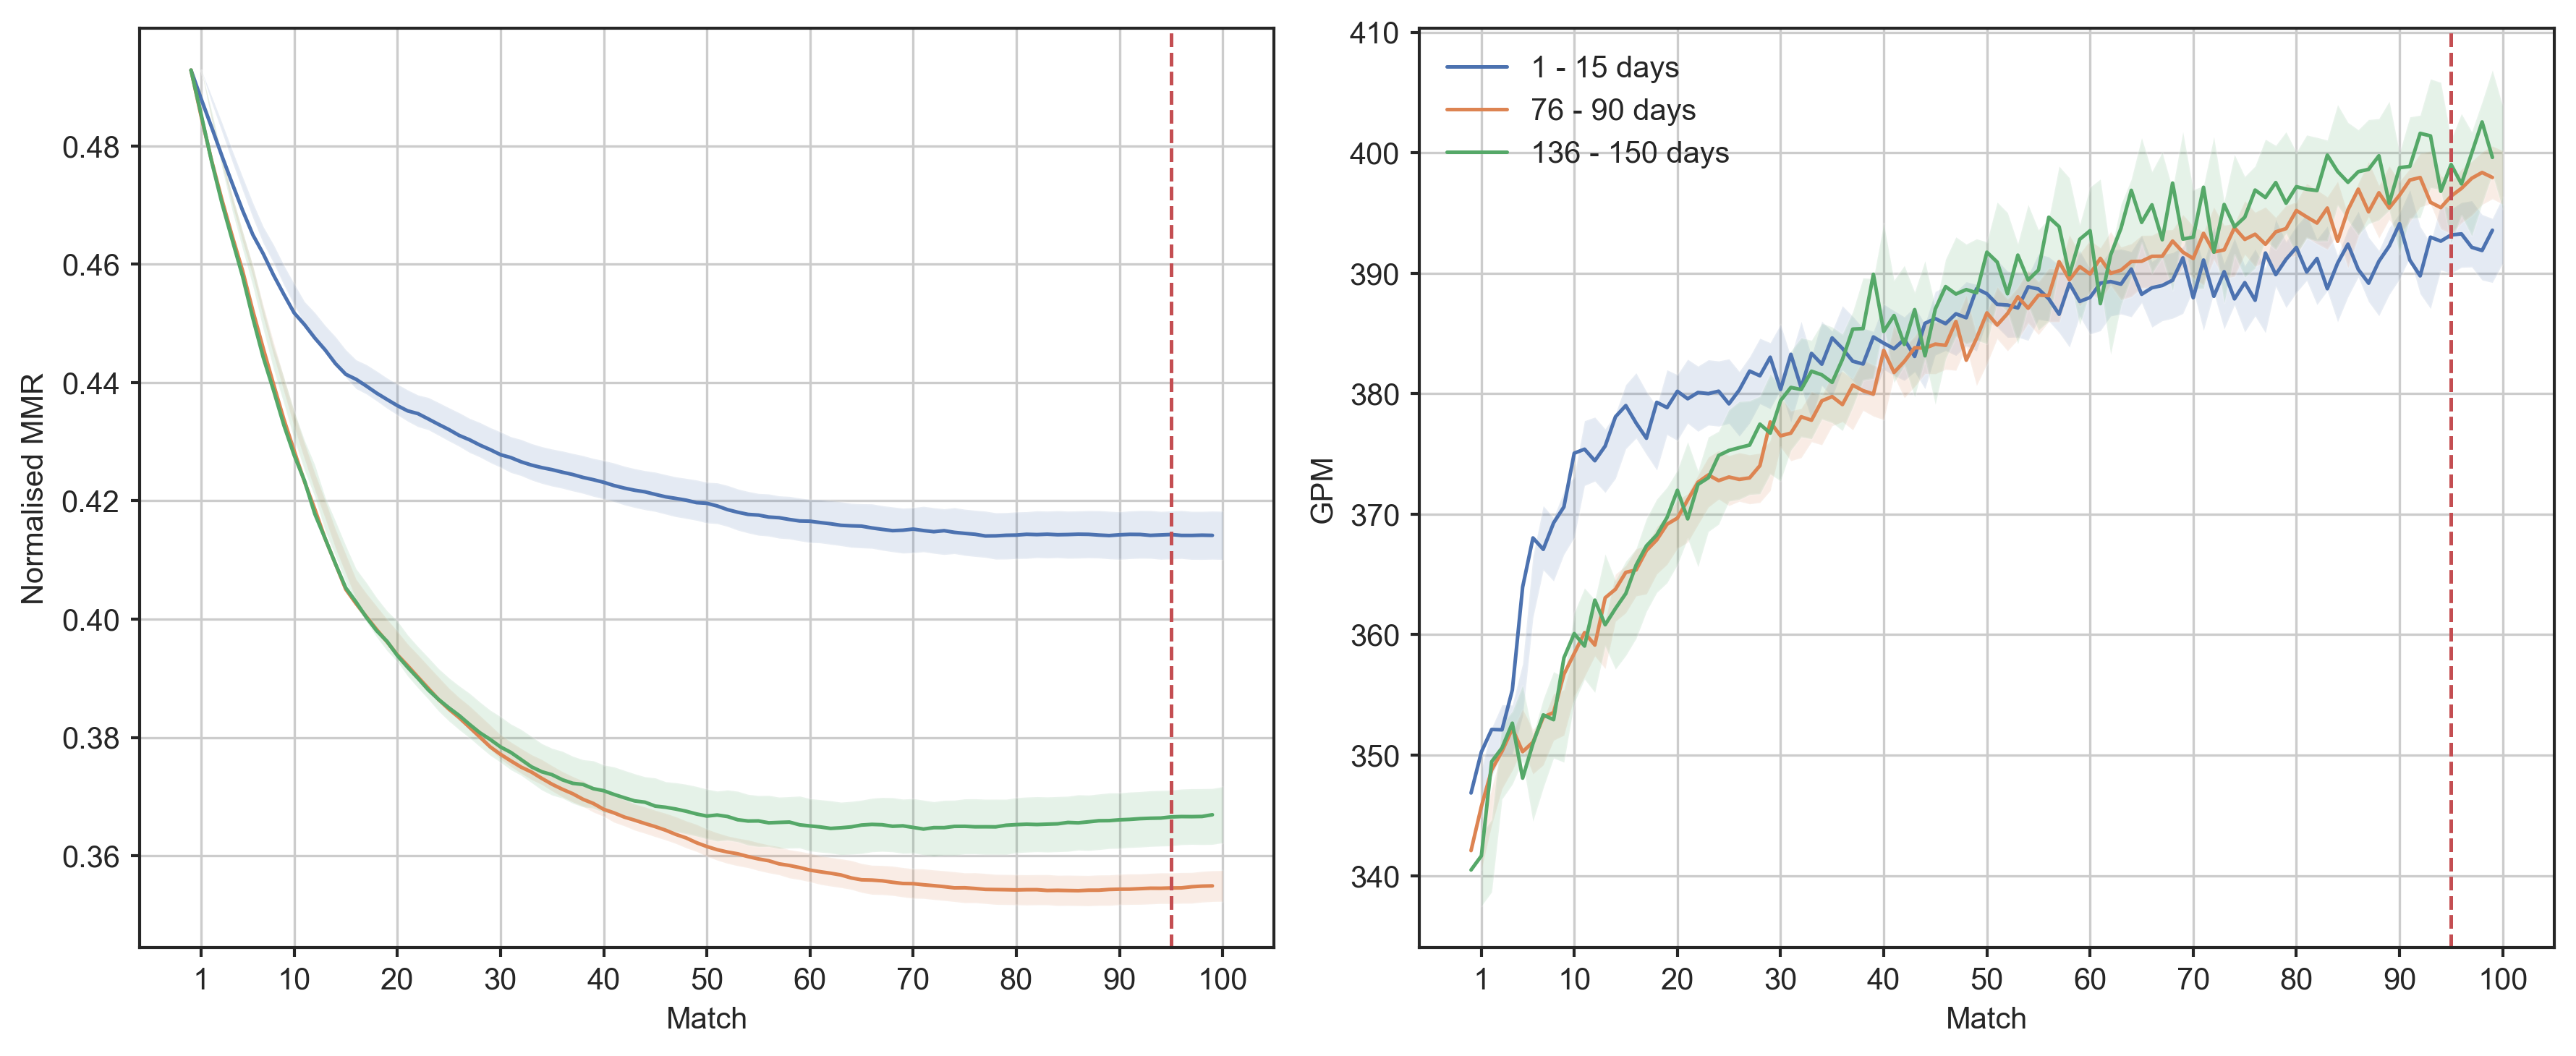

In [22]:
curves_visualizer(
    df=groups_df,
    grouper='rule_cluster',
    targets=TARGETS,
    rows=1,
    columns=2,
    n_matches=100,
    fig_size=(12, 5),
    fig_dir=fig_dir,
    fig_name=f'alt_matched_spacing_groups_normalised_mmr_gpm_trajectories_{n_matches}_matches',
    grouper_rmp=None,
    target_rmp=target_rmp,
    legend=True,
    accounts_to_retain=accounts_to_retain)